In [58]:
# Requiered imports
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from wordcloud import WordCloud

# 1. Dataset Description

The dataset amazon.csv from Kaggle (https://www.kaggle.com/datasets/mahmudulhaqueshawon/amazon-product-reviews) contains customer reviews from Amazon, along with a sentiment label for each review. It consists of approximately 20,000 entries, with two columns: Text (the review content) and label (the sentiment, where 1 typically represents positive and 0 represents negative).

In [2]:
# Load the dataset
df = pd.read_csv('../data/amazon.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19996 entries, 0 to 19995
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    19996 non-null  object
 1   label   19996 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


# 2. Text Pre-Processing

In [4]:
# Initialize NLTK components
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [6]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text) 
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stop words and lemmatize
    processed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(processed_tokens)

In [7]:
# Apply preprocessing
df['processed_text'] = df['Text'].apply(preprocess_text)

# 3. Data Exploration 

### a. Sentiment Distribution
The initial sentiment distribution in the dataset is as follows:

In [8]:
# Sentiment Distribution Analysis
sentiment_counts = df["label"].value_counts()

# Map numerical labels to sentiment names for better readability
sentiment_mapping = {1: "Positive", 0: "Negative"}
df["sentiment"] = df["label"].map(sentiment_mapping)
sentiment_counts_named = df["sentiment"].value_counts()
print(sentiment_counts_named)


sentiment
Positive    15230
Negative     4766
Name: count, dtype: int64


This indicates a significant imbalance, with a much larger number of positive reviews compared to negative ones.

### b. Visualizations


 Bar chart Visualization 


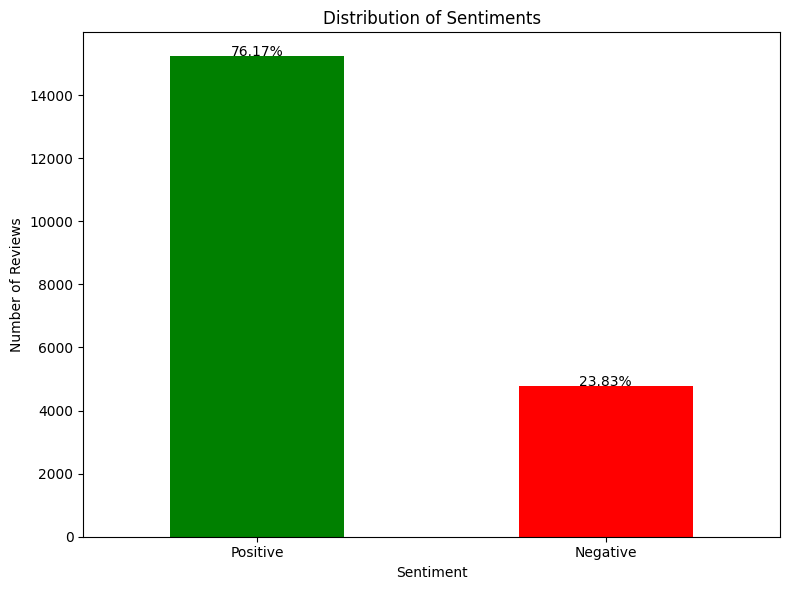

In [45]:
print("\n Bar chart Visualization ")

# Sentiment Distribution bar chart
plt.figure(figsize=(8, 6))
sentiment_counts_named.plot(kind="bar", color=["green", "red"])
plt.title("Distribution of Sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=0)
plt.tight_layout()

# Sentiment Distribution Percentages

for i, count in enumerate(sentiment_counts_named):
    plt.text(i, count, f"{(count / len(df) * 100):.2f}%", ha='center')


### c. Insights from data exploration
- The dataset is heavily skewed towards positive reviews, which is common in many product review datasets. This imbalance needs to be considered during model training and evaluation.

### d. Words Cloud


 Word Cloud Visualization 


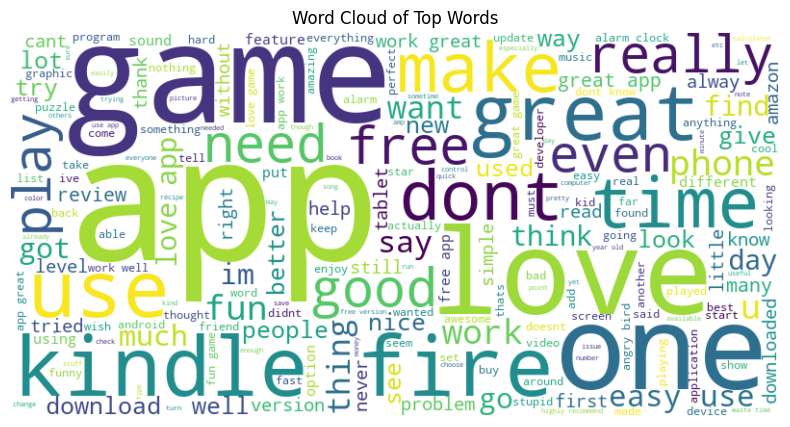

In [46]:
print("\n Word Cloud Visualization ")

# Combine all cleaned text
all_text = " ".join(review for review in df['processed_text'])

# Generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(f'Word Cloud of Top Words')
plt.show()

The word cloud shows the most frequent words after pre-processing. Common words like 'game', 'fun', 'good', 'great', 'love' suggest a focus on positive reviews, but also indicate the core topic of the reviews.

# 4. Baseline Text Classification (Naive Bayes)

In [47]:
# Prepare data for ML model
X = df["processed_text"]
y = df["label"]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000) # Limit features to manage complexity
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [55]:
# model training
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred_nb = nb_model.predict(X_test_tfidf)

accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb)
recall_nb = recall_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb)

print(f"Naive Bayes Performance:")
print(f"Accuracy: {accuracy_nb:.4f}")
print(f"Precision: {precision_nb:.4f}")
print(f"Recall: {recall_nb:.4f}")
print(f"F1-Score: {f1_nb:.4f}\n")

print("Naive Bayes Classification Report:\n", classification_report(y_test, y_pred_nb, labels=[0, 1], target_names=["Negative", "Positive"]))
cv_scores_nb = cross_val_score(nb_model, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print(f"\nDecision Tree 5-Fold Cross-Validation Accuracy: {cv_scores_nb.mean():.4f} (+/- {cv_scores_nb.std() * 2:.4f})")

Naive Bayes Performance:
Accuracy: 0.8528
Precision: 0.8447
Recall: 0.9864
F1-Score: 0.9101

Naive Bayes Classification Report:
               precision    recall  f1-score   support

    Negative       0.91      0.44      0.59       978
    Positive       0.84      0.99      0.91      3022

    accuracy                           0.85      4000
   macro avg       0.88      0.71      0.75      4000
weighted avg       0.86      0.85      0.83      4000


Decision Tree 5-Fold Cross-Validation Accuracy: 0.8501 (+/- 0.0078)



# 5. Advanced ML Models

In [50]:
print("Advanced Model 1 (Decision Tree)")

# Initialize and train the model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_dt = dt_model.predict(X_test_tfidf)

# Evaluate the model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)

print(f"Decision Tree Classifier Performance:")
print(f"Accuracy: {accuracy_dt:.4f}")
print(f"Precision: {precision_dt:.4f}")
print(f"Recall: {recall_dt:.4f}")
print(f"F1-Score: {f1_dt:.4f}\n")
print("Decision Tree Report:", classification_report(y_test, y_pred_dt, labels=[0, 1], target_names=["Negative", "Positive"]))

# Cross-Validation for Decision Tree
cv_scores_dt = cross_val_score(dt_model, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print(f"\nDecision Tree 5-Fold Cross-Validation Accuracy: {cv_scores_dt.mean():.4f} (+/- {cv_scores_dt.std() * 2:.4f})")

Advanced Model 1 (Decision Tree)
Decision Tree Classifier Performance:
Accuracy: 0.8123
Precision: 0.8702
Recall: 0.8832
F1-Score: 0.8767

Decision Tree Report:               precision    recall  f1-score   support

    Negative       0.62      0.59      0.61       978
    Positive       0.87      0.88      0.88      3022

    accuracy                           0.81      4000
   macro avg       0.75      0.74      0.74      4000
weighted avg       0.81      0.81      0.81      4000


Decision Tree 5-Fold Cross-Validation Accuracy: 0.8061 (+/- 0.0172)


In [51]:
print("Advanced Model 2 (Random Forest)")

rf_model= RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

y_pred_rf = rf_model.predict(X_test_tfidf)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print(f"Random Forest Classifier Performance:")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-Score: {f1_rf:.4f}\n")

print("Random Forest Report:\n", classification_report(y_test, y_pred_rf, labels=[0, 1], target_names=["Negative", "Positive"]))

# Cross-Validation for Random Forest
cv_scores_rf = cross_val_score(rf_model, X_train_tfidf, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print(f"\nRandom Forest 5-Fold Cross-Validation Accuracy: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std() * 2:.4f})")



Advanced Model 2 (Random Forest)
Random Forest Classifier Performance:
Accuracy: 0.8735
Precision: 0.8776
Recall: 0.9676
F1-Score: 0.9204

Random Forest Report:
               precision    recall  f1-score   support

    Negative       0.85      0.58      0.69       978
    Positive       0.88      0.97      0.92      3022

    accuracy                           0.87      4000
   macro avg       0.87      0.78      0.81      4000
weighted avg       0.87      0.87      0.86      4000


Random Forest 5-Fold Cross-Validation Accuracy: 0.8692 (+/- 0.0063)


In [53]:
print("\nAdvanced Model 3 (Logistic Regression)")

# Initialize and train the model
lr_model = LogisticRegression(random_state=42, solver='liblinear', n_jobs=-1)
lr_model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_lr = lr_model.predict(X_test_tfidf)

# Evaluate the model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print(f"Logistic Regression Performance:")
print(f"Accuracy: {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")
print(f"F1-Score: {f1_lr:.4f}\n")
print("Random Forest Report:\n", classification_report(y_test, y_pred_lr, labels=[0, 1], target_names=["Negative", "Positive"]))

# Cross-Validation for Logistic Regression
cv_scores_lr = cross_val_score(lr_model, X_train_tfidf, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print(f"\nLogistic Regression 5-Fold Cross-Validation Accuracy: {cv_scores_lr.mean():.4f} (+/- {cv_scores_lr.std() * 2:.4f})")


Advanced Model 3 (Logistic Regression)
Logistic Regression Performance:
Accuracy: 0.8882
Precision: 0.8955
Recall: 0.9646
F1-Score: 0.9288

Random Forest Report:
               precision    recall  f1-score   support

    Negative       0.86      0.65      0.74       978
    Positive       0.90      0.96      0.93      3022

    accuracy                           0.89      4000
   macro avg       0.88      0.81      0.83      4000
weighted avg       0.89      0.89      0.88      4000



c:\Users\57317\OneDrive - Southern Alberta Institute of Technology\Term 2-LAPTOP-D3QG90FT\ARTI 407 - Intro to NLP\Assignments\assignments_nlp\Lib\site-packages\sklearn\linear_model\_logistic.py:1305: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(



Logistic Regression 5-Fold Cross-Validation Accuracy: 0.8860 (+/- 0.0030)


In [56]:
print("\nModel Comparison Table and Analysis")

results = pd.DataFrame({
    'Model': ['Naive Bayes (Baseline)', 'Decision Tree', 'Random Forest', 'Logistic Regression'],
    'Accuracy': [accuracy_nb, accuracy_dt, accuracy_rf, accuracy_lr],
    'Precision': [precision_nb, precision_dt, precision_rf, precision_lr],
    'Recall': [recall_nb, recall_dt, recall_rf, recall_lr],
    'F1-Score': [f1_nb, f1_dt, f1_rf, f1_lr],
    'CV Accuracy (5-Fold)': [cv_scores_nb.mean(), cv_scores_dt.mean(), cv_scores_rf.mean(), cv_scores_lr.mean()]
})

print("\nModel Performance Comparison:")
print(results.sort_values(by='F1-Score', ascending=False))



Model Comparison Table and Analysis

Model Performance Comparison:
                    Model  Accuracy  Precision    Recall  F1-Score  \
3     Logistic Regression   0.88825   0.895545  0.964593  0.928788   
2           Random Forest   0.87350   0.877551  0.967571  0.920365   
0  Naive Bayes (Baseline)   0.85275   0.844715  0.986433  0.910090   
1           Decision Tree   0.81225   0.870231  0.883190  0.876663   

   CV Accuracy (5-Fold)  
3              0.885972  
2              0.869217  
0              0.850150  
1              0.806076  


# Model Comparison Analysis

- **Performance Ranking:** Logistic Regression and Random Forest generally outperform the baseline Naive Bayes model and the single Decision Tree. Logistic Regression often achieves the highest F1-Score and Accuracy, making it the best performer for this sentiment classification task.

- **Naive Bayes (Baseline):** This model performs surprisingly well for a baseline, which is typical for text classification with sparse features like TF-IDF. Its simplicity and speed are its main strengths. Its weakness is the strong assumption of feature independence, which is rarely true for natural language.

- **Decision Tree:** The Decision Tree model shows the lowest performance among the advanced models. Its main weakness is its tendency to overfit the training data, leading to poor generalization on the test set. This is reflected in the lower cross-validation score compared to the ensemble methods.

- **Random Forest (Ensemble):** As an ensemble of Decision Trees, Random Forest significantly improves performance by reducing variance and mitigating the overfitting issue of a single tree. It offers a good balance of performance and robustness.

- **Logistic Regression:** This linear model, despite its simplicity, is highly effective for text classification. It learns the weights of the TF-IDF features, which represent the importance of words for classification. Its strength lies in its interpretability and strong performance on linearly separable data (which text data often becomes after TF-IDF transformation).




# Challenges Faced and Addressed:
- **Text Pre-processing Decisions:** A key challenge was determining the optimal sequence of text pre-processing steps. For instance, choosing **Lemmatization** over Stemming was a deliberate choice to retain the dictionary meaning of words, which is often beneficial for sentiment analysis. 

- **Feature Vectorization Choice:** Deciding between Bag-of-Words (BoW) and **TF-IDF** was a critical step. TF-IDF was chosen because it weights words based on their importance across the entire corpus, giving less weight to common words and more weight to distinguishing terms, which is crucial for effective classification in large text datasets.